In [1]:
import numpy as np
import pandas as pd
import copy as cp
import matplotlib.pyplot as plt

In [198]:
# Set as 0 if using results from no control simulation
# Set as 1 if using results from control, flow/TSS load simulation
# Set as 2 if using results from control, flow simulation
# Set as 3 if using results from control, TSS load simulation
save = 3

stormNo = '3'

# Load storm event data (LBC results, for sewer subsection only)
# WRRF flow is in units of cubic feet/sec
# WRRF TSS load is in units of lb/sec
# WRRF TSS concentration is in units of mg/L
storm_nocontrol = np.load('../data/storm'+stormNo+'.npy', allow_pickle=True)

if save == 0:
    storm = cp.deepcopy(storm_nocontrol)
    file_c = 'nc'
elif save == 1:
    storm_control = np.load('../data/storm'+stormNo+'_control_both.npy', allow_pickle=True)
    storm = cp.deepcopy(storm_control)
    file_c = 'c_both'
elif save == 2:
    storm_control = np.load('../data/storm'+stormNo+'_control_flow.npy', allow_pickle=True)
    storm = cp.deepcopy(storm_control)
    file_c = 'c_flow'
elif save == 3:
    storm_control = np.load('../data/storm'+stormNo+'_control_TSS.npy', allow_pickle=True)
    storm = cp.deepcopy(storm_control)
    file_c = 'c_TSS'

# File name for influent tsv
w_influentTSV = 'C:/Users/Sara/Desktop/sewerWRRF/data/storm'+stormNo+'_'+file_c+'_influent.tsv'

In [199]:
# Check storm event data contents
storm

array({'time': array([[28.],
       [28.],
       [28.],
       ...,
       [37.],
       [37.],
       [37.]], dtype=float16), 'WRRF_flow': array([[199.63414],
       [199.63525],
       [199.63641],
       ...,
       [198.72772],
       [198.724  ],
       [198.72041]], dtype=float32), 'WRRF_TSSLoad': array([[1.9765158],
       [1.9765999],
       [1.9766845],
       ...,
       [1.9710642],
       [1.9710968],
       [1.971131 ]], dtype=float32), 'WRRF_TSSConc': array([[158.54905228],
       [158.55490593],
       [158.56077603],
       ...,
       [158.83290506],
       [158.83849563],
       [158.84411908]]), 'WRRF_flow_dry': array([198.01916504, 198.01844788, 198.01780701, ..., 198.72772217,
       198.72399902, 198.72041321]), 'WRRF_TSSLoad_dry': array([1.97024274, 1.97030628, 1.97037041, ..., 1.97106421, 1.97109675,
       1.97113097]), 'WRRF_flow_wet': array([1.61497498, 1.61680603, 1.61860657, ..., 0.        , 0.        ,
       0.        ]), 'WRRF_TSSLoad_wet': array([0.006

Text(0, 0.5, 'Sewer Flow (m3/s)')

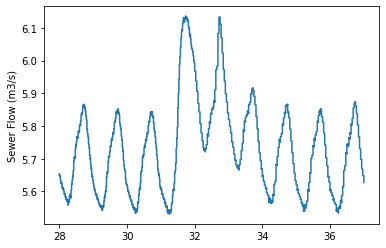

In [200]:
# Flow in sewer subsection (only)
# Units of m3/s (converted from ft3/s)
sewer_flow = storm.item().get('WRRF_flow') / 35.3147
plt.plot(storm.item().get('time'),sewer_flow)
plt.ylabel('Sewer Flow (m3/s)')

Text(0, 0.5, 'Sewer TSS Load (lb/s)')

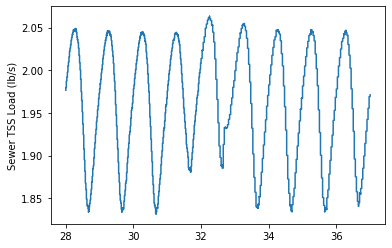

In [201]:
# TSS load in sewer subsection (only)
plt.plot(storm.item().get('time'),storm.item().get('WRRF_TSSLoad'))
plt.ylabel('Sewer TSS Load (lb/s)')

Text(0, 0.5, 'NO CONTROL Sewer Flow (m3/s)')

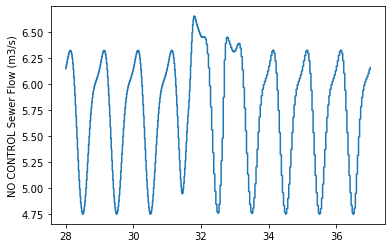

In [202]:
# Flow in sewer subsection (only)
# NO CONTROL results shown here
# Units of m3/s (converted from ft3/s)
plt.plot(storm_nocontrol.item().get('time'),storm_nocontrol.item().get('WRRF_flow') / 35.3147)
plt.ylabel('NO CONTROL Sewer Flow (m3/s)')

5.667705577043369

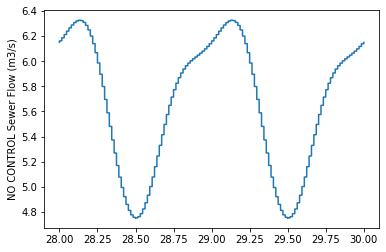

In [203]:
# Plot section that is dry-weather only
# Will average over this section to get dry-weather average value
# This is done for the NO CONTROL results shown above
# Units of m3/s (converted from ft3/s)
# Storm 1: 5:-1
# Storm 2: 13:-1
# Storm 3: 0:2

dw_start = 0*24*60*60/10
dw_end = 2*24*60*60/10
plt.plot(storm_nocontrol.item().get('time')[int(dw_start):int(dw_end)],storm_nocontrol.item().get('WRRF_flow')[int(dw_start):int(dw_end)] / 35.3147)
plt.ylabel('NO CONTROL Sewer Flow (m3/s)')

# Units of m3/s
seweroutflow = np.mean(storm_nocontrol.item().get('WRRF_flow')[int(dw_start):int(dw_end)]) / 35.3147
seweroutflow

In [204]:
### OLD Using ./data/flowPrecip.xlsx average dry-weather WRRF inflow is about 520.30 Mgal/d (1,969,500 m3/d, )
### OLD Average WRRF inflow is 2,788,860 m3/d

# Using GLWA WRRF model, steady-state flow is 2,100,000 m3/d
# Converting m3/d to m3/s ...
WRRFinflow = 2100000 / 86400
WRRFinflow

24.305555555555557

In [205]:
# Ratio to scale from sewer subsection to GLWA WRRF influent
# Ratio should be about 4.2885
scale_ratio = WRRFinflow/seweroutflow
scale_ratio

4.288429457945637

Text(0, 0.5, 'WRRF Flow (m3/s)')

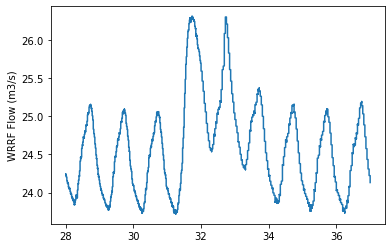

In [206]:
# Flow for GLWA WRRF influent
# Units of m3/s
plt.plot(storm.item().get('time'),scale_ratio*sewer_flow)
plt.ylabel('WRRF Flow (m3/s)')

Text(0, 0.5, 'WRRF Flow (m3/d)')

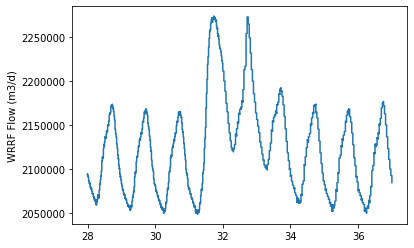

In [207]:
# Need flow for GLWA WRRF influent in units of m3/d (converted from m3/s)
WRRF_flow = scale_ratio*sewer_flow * 86400

plt.plot(storm.item().get('time'),WRRF_flow)
plt.ylabel('WRRF Flow (m3/d)')

Text(0, 0.5, 'WRRF TSS Load (lb/s)')

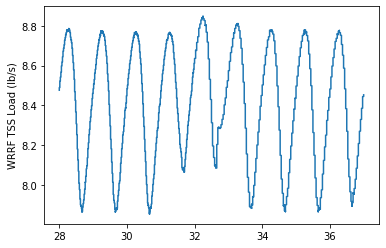

In [208]:
# TSS load for GLWA WRRF influent
plt.plot(storm.item().get('time'),scale_ratio*storm.item().get('WRRF_TSSLoad'))
plt.ylabel('WRRF TSS Load (lb/s)')

Text(0, 0.5, 'WRRF TSS Concentration (mg/L)')

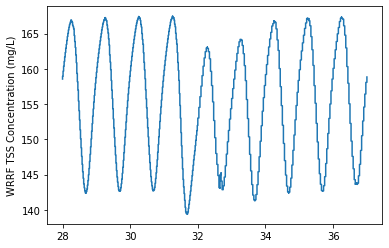

In [209]:
# TSS concentration for GLWA WRRF influent (same as that for sewer subsection since concentration)
plt.plot(storm.item().get('time'),storm.item().get('WRRF_TSSConc'))
plt.ylabel('WRRF TSS Concentration (mg/L)')

In [210]:
# Using GLWA WRRF model, steady-state ...
# flow is 2,100,000 m3/d,
# TCOD is 210 mg TCOD/L,
# TKN is 20 mg N/L,
# influent TP is 2.2 mg P/L, 
# fraction of PO4 in TP is 53.3%, so influent SP is 1.1726 mg P/L,
# temperature is 10 C

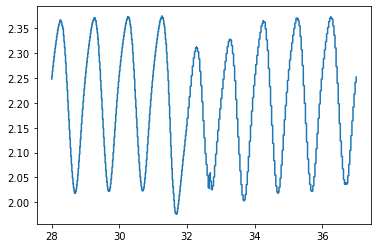

In [211]:
# For simplification, TCOD, TKN, and TP will mirror TSS dynamics
# TP will only include total phosphorus without fractionation
# The fraction of PO4 in TP will be kept at a constant value of 53.5%
# Temperature will be a constant value of 10 C

# TCOD concentration in mg/L
WRRF_TCODConc = storm.item().get('WRRF_TSSConc') / np.mean(storm.item().get('WRRF_TSSConc')) * 210

# TKN concentration in mg/L
WRRF_TKNConc = storm.item().get('WRRF_TSSConc') / np.mean(storm.item().get('WRRF_TSSConc')) * 20

# TP concentration in mg/L
WRRF_TPConc = storm.item().get('WRRF_TSSConc') / np.mean(storm.item().get('WRRF_TSSConc')) * 2.2

# PO4 in TP in fraction
WRRF_frPO4TP = 0.533*np.ones_like(storm.item().get('WRRF_TSSConc'))

# Temperature in C
WRRF_T = 10*np.ones_like(storm.item().get('WRRF_TSSConc'))

# Non-influent related items

# Fe mass dose in kg/d
# For base-case, set as zero
Femass = np.zeros_like(storm.item().get('WRRF_TSSConc'))

# Primary clarifier solids fraction removal in fraction
# Assume steady-state of 70%
fXTSS_sludge = 0.7*np.ones_like(storm.item().get('WRRF_TSSConc'))

# Primary clarifier sludge flow in m3/d
# Assume steady-state of 20,000 m3/d
Qsludge_target = 20000*np.ones_like(storm.item().get('WRRF_TSSConc'))

plt.plot(storm.item().get('time'),WRRF_TPConc)

In [212]:
storm_df = pd.DataFrame(data=np.column_stack((storm.item().get('time'), # d
                                        WRRF_flow, # m3/d
                                        WRRF_TCODConc, # mg/L
                                        WRRF_TKNConc, # mg/L
                                        WRRF_TPConc, # mg/L
                                        WRRF_frPO4TP, # fraction
                                        WRRF_T, # C
                                        Femass, # kg/d
                                        fXTSS_sludge, # fraction
                                        Qsludge_target)), # m3/d
                  columns=['Sumo__Time',
                           'Sumo__Plant__Influent__param__Q',
                           'Sumo__Plant__Influent__param__TCOD',
                           'Sumo__Plant__Influent__param__TKN',
                           'Sumo__Plant__Influent__param__TP',
                           'Sumo__Plant__Influent__param__frSPO4_TP',
                           'Sumo__Plant__Influent__param__T',
                           'Sumo__Plant__Metal1__param__Femass',
                           'Sumo__Plant__Primary1__param__fXTSS_sludge',
                           'Sumo__Plant__Primary1__param__Qsludge_target'])
storm_df

,Sumo__Time,Sumo__Plant__Influent__param__Q,Sumo__Plant__Influent__param__TCOD,Sumo__Plant__Influent__param__TKN,Sumo__Plant__Influent__param__TP,Sumo__Plant__Influent__param__frSPO4_TP,Sumo__Plant__Influent__param__T,Sumo__Plant__Metal1__param__Femass,Sumo__Plant__Primary1__param__fXTSS_sludge,Sumo__Plant__Primary1__param__Qsludge_target
0,28.0,2.094553e+06,214.577931,20.435993,2.247959,0.533,10.0,0.0,0.7,20000.0
1,28.0,2.094564e+06,214.585853,20.436748,2.248042,0.533,10.0,0.0,0.7,20000.0
2,28.0,2.094576e+06,214.593797,20.437505,2.248125,0.533,10.0,0.0,0.7,20000.0
3,28.0,2.094589e+06,214.601742,20.438261,2.248209,0.533,10.0,0.0,0.7,20000.0
4,28.0,2.094601e+06,214.609664,20.439016,2.248292,0.533,10.0,0.0,0.7,20000.0
...,...,...,...,...,...,...,...,...,...,...
77755,37.0,2.085126e+06,214.946894,20.471133,2.251825,0.533,10.0,0.0,0.7,20000.0
77756,37.0,2.085083e+06,214.954482,20.471855,2.251904,0.533,10.0,0.0,0.7,20000.0
77757,37.0,2.085043e+06,214.962093,20.472580,2.251984,0.533,10.0,0.0,0.7,20000.0
77758,37.0,2.085003e+06,214.969659,20.473301,2.252063,0.533,10.0,0.0,0.7,20000.0


In [213]:
with open(w_influentTSV,'w') as write_tsv:
    write_tsv.write(storm_df.to_csv(sep='\t', index=False))